# Monte Carlo Agent for Cartpole Problem

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from abc import ABC, abstractmethod
from typing import NamedTuple
import pickle
from collections import defaultdict

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


In [4]:
env = gym.make("CartPole-v1")

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [6]:
class Observation(NamedTuple):
    cart_pos: int
    cart_vel: int
    pole_angle: int
    pole_vel: int

def discretize_state(observation):
  #
    cart_pos_bins = np.linspace(-4.8, 4.8, 10)
    cart_vel_bins = np.linspace(-5, 5, 10)
    pole_angle_bins = np.linspace(-0.418, 0.418, 10)
    pole_vel_bins = np.linspace(-5, 5, 10)

    return Observation(
        np.digitize(observation[0], cart_pos_bins),
        np.digitize(observation[1], cart_vel_bins),
        np.digitize(observation[2], pole_angle_bins),
        np.digitize(observation[3], pole_vel_bins)
    )

## Task 1: Development of an RL agent

In Reinforcement Learning, we have an agent that interacts with the environment by performing an action (A) at each time step t. The environment then responds to the action with a new state (S) and reward (R). The agent takes the new state and reward into consideration when performing yet another action. The agent’s goal is to perform actions that will maximize the total reward it receives over the long run.

**Action Selection Strategy: Epsilon-Greedy**

How each action is chosen is defined within choose_action. The value of self-epsilon determines the amount of exploration and exploitation- so a self.epsilon = 0.2 would mean 20% exploration. If np.random.uniform(0,1) returns a value less than self.epsilon, the agent will explore - which means choose a random action.

If np.random.uniform(0,1) returns a value higher than self.epsilon, the agent will exploit - which means choose the action with the highest estimated Q-value. (explained below)

A high epsilon encourages more exploration, while a low epsilon favors exploiting the current best actions. The value of epsilon needs to be tuned for the specific problem, so we try different values to find the value that creates the best agent.

**Q-Value Updating**

*Return* refers to the function of the discounted reward sequence with discount rate 𝛾 (0 ≤ 𝛾 ≤ 1). Return G at time step t is calculated as follows:
```
G_t = R_{t+1} + γ * R_{t+2} + γ^2 * R_{t+3} + ...
```
A higher gamma value gives more weight to future rewards, and the limit is 1, at which point future rewards are just as important as immediate rewards. If gamma is 0, the agent only considers immediate rewards. In this code, we tried different values of gamma to find the optimal discount rate for this problem.

*Policy* is a mapping from states to the probabilities of selecting each possible action. The policy is what we want to learn and optimize so that it maximizes the expected return over the long run.

*Value Function* is a function that estimates the expected return starting from a given state (or state-action pair) and following a policy. This agent uses action-value function, or Q-function, which is a type of value function that estimates the value of taking a specific action (A) in a particular state (S).

Our agent interacts with the environment, runs full episodes and after each episode, runs update_Q to update its Q-value estimates. The update rule in update_Q updates the Q-value of a state-action pair using the following formula:
```
`Q(s, a) = Q(s, a) + α * [R + γ * max_a' Q(s', a') - Q(s, a)]`
```
The formula updates Q-value of a state-action pair (Q(s,a)) based on the difference between the actual return (G) observed during an episode and the current estimated Q-value. The learning rate (alpha) controls the magnitude of this adjustment. This is **Monte Carlo Q-Evaluation**.

The hyperparameters, thus, are as follows:

1. Alpha
2. Gamma
3. Epsilon






In [30]:
class MonteCarloAgent: # random default values for hyperparameters
    def __init__(self, action_space_size, load_from_file=True, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
      self.action_space_size = action_space_size
      self.alpha = alpha  # learning rate
      self.gamma = gamma  # discount factor
      self.epsilon = epsilon  # exploration %
      self.epsilon_min = epsilon_min
      self.epsilon_decay = epsilon_decay

      # use defaultdict to dynamically store Q-values
      self.Q = defaultdict(lambda: 10)  # high Q-values for optimism
      self.returns = defaultdict(list)
      self.N = defaultdict(int)
      self.filename = "mc_q_table.pkl"

      # load Q-table if available
      if load_from_file:
        self.load_q_table()

    def save_q_table(self):
      with open(self.filename, "wb") as file:
        pickle.dump((dict(self.Q), dict(self.returns), dict(self.N)), file)

    def load_q_table(self):
      try:
        with open(self.filename, "rb") as file:
          self.Q, self.returns, self.N = pickle.load(file)
          self.Q = defaultdict(int, self.Q)
          self.returns = defaultdict(list, self.returns)
          self.N = defaultdict(int, self.N)
      except (EOFError, FileNotFoundError):
        print("No saved Q-table found. starting fresh.")


    # decay epsilon over time to encourage exploitation over time
    def decay_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def reset_q_table(self):
      self.Q = defaultdict(lambda: 10)
      self.returns = defaultdict(list)
      self.N = defaultdict(int)
      self.save_q_table()

    def choose_action(self, state):
      # epsilon-greedy action selection
      if np.random.uniform(0, 1) < self.epsilon:
        return np.random.choice(self.action_space_size) # explore
      else:
        return np.argmax([self.Q[(state, a)] for a in range(self.action_space_size)]) # exploit

    # update_Q will be called at the end of each episode. it takes the entire episode's experience as input
    # and calculates the return G for each state-action pair throughout the episode and accumulating the
    # rewards. Q-value for each state-action pair is updated using the calculated return G
    def update_Q(self, episode):
      G = 0
      visited_state_action_pairs = set()

      for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = self.gamma * G + reward

        # first-visit Monte Carlo - compared to every-visit, often preferred due to its faster convergence
        if (state, action) not in visited_state_action_pairs:
          visited_state_action_pairs.add((state, action))
          self.returns[(state, action)].append(G)
          self.N[state, action] += 1

          # updating Q-value using the learning rate (alpha)
          self.Q[state, action] += self.alpha * (G - self.Q[state, action])

      self.save_q_table()  # save progress after every episode

Now, we train the agent, using a wide range of values for each hyperparameter (alpha, gamma, epsilon) from 0 to 1, to find if higher or lower values are optimal for each hyperparameter, in the context of this problem.

For each combination of hyperparameters we run 3 trials of 500 episodes and the results dictionary stores the average reward across trials.

We will then use the hyperparameter combination with the highest average rewards to train a best agent.

In [33]:
alphas = [0.1, 0.25, 0.5, 0.75] # lower to higher learning rate
gammas = [0.5, 0.7, 0.9, 0.99]  # lower to higher discount rate
epsilons = [0.2, 0.4, 0.6]  # less to more exploration

num_trials = 3  # number of trials per combination
num_episodes = 500

results = {}

for alpha in alphas:
  for gamma in gammas:
    for epsilon in epsilons:
      trial_rewards = []
      for trial in range(num_trials):
        agent = MonteCarloAgent(env.action_space.n, alpha=alpha, gamma=gamma, epsilon=epsilon)
        agent.reset_q_table()
        for episode in range(num_episodes):
          observation = env.reset()
          episode = []
          episode_rewards = []  # rewards for each episode within a trial
          cumulative_reward = 0
          done = False

          while not done:
            state = discretize_state(observation)
            action = agent.choose_action(state)
            observation, reward, done, info = env.step(action)

            cart_pos, cart_vel, pole_angle, pole_vel = observation

            # termination check
            if abs(pole_angle) > 0.2094 or abs(cart_pos) > 2.4:
              done = True

            episode.append((state, action, reward))
            cumulative_reward += reward

          agent.update_Q(episode)
          agent.decay_epsilon()
          episode_rewards.append(cumulative_reward)  # rewards for episode

        trial_rewards.append(np.mean(episode_rewards))  # average reward for trial
        print(f"Trial {trial + 1} for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete.")

      results[(alpha, gamma, epsilon)] = np.mean(trial_rewards)  # average reward across trials
      print(f"Trials for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete. Average reward: {results[(alpha, gamma, epsilon)]}")

No saved Q-table found. starting fresh.
Trial 1 for alpha=0.1, gamma=0.5, epsilon=0.2 complete.
Trial 2 for alpha=0.1, gamma=0.5, epsilon=0.2 complete.
Trial 3 for alpha=0.1, gamma=0.5, epsilon=0.2 complete.
Trials for alpha=0.1, gamma=0.5, epsilon=0.2 complete. Average reward: 88.0
Trial 1 for alpha=0.1, gamma=0.5, epsilon=0.4 complete.
Trial 2 for alpha=0.1, gamma=0.5, epsilon=0.4 complete.
Trial 3 for alpha=0.1, gamma=0.5, epsilon=0.4 complete.
Trials for alpha=0.1, gamma=0.5, epsilon=0.4 complete. Average reward: 106.0
Trial 1 for alpha=0.1, gamma=0.5, epsilon=0.6 complete.
Trial 2 for alpha=0.1, gamma=0.5, epsilon=0.6 complete.
Trial 3 for alpha=0.1, gamma=0.5, epsilon=0.6 complete.
Trials for alpha=0.1, gamma=0.5, epsilon=0.6 complete. Average reward: 97.33333333333333
Trial 1 for alpha=0.1, gamma=0.7, epsilon=0.2 complete.
Trial 2 for alpha=0.1, gamma=0.7, epsilon=0.2 complete.
Trial 3 for alpha=0.1, gamma=0.7, epsilon=0.2 complete.
Trials for alpha=0.1, gamma=0.7, epsilon=0.2 c

In [34]:
best_params = max(results, key=results.get)
best_reward = results[best_params]

print(f"Best Hyperparameters: {best_params}")
print(f"Best Average Reward: {best_reward}")

Best Hyperparameters: (0.1, 0.99, 0.2)
Best Average Reward: 353.6666666666667


We know now that the best learning rate is on the lower end of 0 to 1, the best discount rate is on the higher end of 0 to 1 and the best epsilon value is on the lower end of 0 to 1.

Let's run the hyperparameter tuning again, but with more values around the 'best range' specified for each value.

In [37]:
alphas = [0.01, 0.05, 0.1]
gammas = [0.99, 0.995, 0.999]
epsilons = [0.15, 0.20, 0.25]

num_trials = 5  # more trials - outliers don't change the average too much
num_episodes = 500

results = {}

for alpha in alphas:
  for gamma in gammas:
    for epsilon in epsilons:
      trial_rewards = []
      for trial in range(num_trials):
        agent = MonteCarloAgent(env.action_space.n, alpha=alpha, gamma=gamma, epsilon=epsilon)
        agent.reset_q_table()
        for episode in range(num_episodes):
          observation = env.reset()
          episode = []
          episode_rewards = []  # rewards for each episode within a trial
          cumulative_reward = 0
          done = False

          while not done:
            state = discretize_state(observation)
            action = agent.choose_action(state)
            observation, reward, done, info = env.step(action)

            cart_pos, cart_vel, pole_angle, pole_vel = observation

            # termination check
            if abs(pole_angle) > 0.2094 or abs(cart_pos) > 2.4:
              done = True

            episode.append((state, action, reward))
            cumulative_reward += reward

          agent.update_Q(episode)
          agent.decay_epsilon()
          episode_rewards.append(cumulative_reward)  # rewards for episode

        trial_rewards.append(np.mean(episode_rewards))  # average reward for trial
        print(f"Trial {trial + 1} for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete.")

      results[(alpha, gamma, epsilon)] = np.mean(trial_rewards)  # average reward across trials
      print(f"Trials for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete. Average reward: {results[(alpha, gamma, epsilon)]}")

Trial 1 for alpha=0.01, gamma=0.99, epsilon=0.15 complete.
Trial 2 for alpha=0.01, gamma=0.99, epsilon=0.15 complete.
Trial 3 for alpha=0.01, gamma=0.99, epsilon=0.15 complete.
Trial 4 for alpha=0.01, gamma=0.99, epsilon=0.15 complete.
Trial 5 for alpha=0.01, gamma=0.99, epsilon=0.15 complete.
Trials for alpha=0.01, gamma=0.99, epsilon=0.15 complete. Average reward: 111.4
Trial 1 for alpha=0.01, gamma=0.99, epsilon=0.2 complete.
Trial 2 for alpha=0.01, gamma=0.99, epsilon=0.2 complete.
Trial 3 for alpha=0.01, gamma=0.99, epsilon=0.2 complete.
Trial 4 for alpha=0.01, gamma=0.99, epsilon=0.2 complete.
Trial 5 for alpha=0.01, gamma=0.99, epsilon=0.2 complete.
Trials for alpha=0.01, gamma=0.99, epsilon=0.2 complete. Average reward: 185.8
Trial 1 for alpha=0.01, gamma=0.99, epsilon=0.25 complete.
Trial 2 for alpha=0.01, gamma=0.99, epsilon=0.25 complete.
Trial 3 for alpha=0.01, gamma=0.99, epsilon=0.25 complete.
Trial 4 for alpha=0.01, gamma=0.99, epsilon=0.25 complete.
Trial 5 for alpha=0.

In [38]:
best_params = max(results, key=results.get)
best_reward = results[best_params]

print(f"Best Hyperparameters: {best_params}")
print(f"Best Average Reward: {best_reward}")

Best Hyperparameters: (0.05, 0.99, 0.15)
Best Average Reward: 352.2


The best hyperparameters are as follows:

Alpha = 0.05

Gamma = 0.99

Epsilon = 0.15, 15% exploration

Now, train the agent using the best combination of hyperparameters for 10000 episodes - or until best performance.

In [39]:
env = gym.make("CartPole-v1")
agent = MonteCarloAgent(env.action_space.n, alpha=0.05, gamma=0.99, epsilon=0.15)
agent.reset_q_table()

#train
episode_results = []
episode_num = 0
consistent = False

while not consistent:
  observation = env.reset()
  episode = []
  cumulative_reward = 0
  done = False

  while not done:
    state = discretize_state(observation)
    action = agent.choose_action(state)
    observation, reward, done, info = env.step(action)

    cart_pos, cart_vel, pole_angle, pole_vel = observation

    # termination check based on constraints
    if abs(pole_angle) > 0.2094 or abs(cart_pos) > 2.4:
        done = True  # terminate episode

    episode.append((state, action, reward))
    cumulative_reward += reward

  agent.update_Q(episode)
  episode_num += 1

  agent.decay_epsilon()
  episode_results.append(cumulative_reward)

  # if results = 500 for last 100 episodes, stop training
  if episode_num >= 100:
    score = episode_results[-100:]
    if (episode_num+1) % 100 == 0:
      print(f"Episode {episode_num + 1}: Score = {np.mean(score)}") # score is the avg rewards of last 100 episodes
    if np.mean(score) == 500 or episode_num == 10000:
      consistent = True
      print("Training stopped due to consistent performance.")


Episode 200: Score = 193.61
Episode 300: Score = 187.95
Episode 400: Score = 220.52
Episode 500: Score = 181.64
Episode 600: Score = 267.38
Episode 700: Score = 212.33
Episode 800: Score = 227.67
Episode 900: Score = 214.31
Episode 1000: Score = 224.33
Episode 1100: Score = 239.74
Episode 1200: Score = 176.47
Episode 1300: Score = 403.71
Episode 1400: Score = 360.95
Episode 1500: Score = 369.05
Episode 1600: Score = 359.03
Episode 1700: Score = 267.95
Episode 1800: Score = 342.61
Episode 1900: Score = 341.37
Episode 2000: Score = 285.46
Episode 2100: Score = 334.94
Episode 2200: Score = 355.79
Episode 2300: Score = 364.66
Episode 2400: Score = 273.97
Episode 2500: Score = 371.96
Episode 2600: Score = 370.71
Episode 2700: Score = 276.23
Episode 2800: Score = 358.17
Episode 2900: Score = 322.76
Episode 3000: Score = 436.1
Episode 3100: Score = 362.97
Episode 3200: Score = 415.0
Episode 3300: Score = 291.31
Episode 3400: Score = 282.46
Episode 3500: Score = 322.8
Episode 3600: Score = 295

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, the MC agent developed in Task 1 plays the game for 100 episodes. The cumulative reward for each round is recorded and plotted. A sample plotting code is given below.

In [40]:
eval_rewards = []
num_eval_episodes = 100

for episode_num in range(num_eval_episodes):
    observation = env.reset()
    episode_reward = 0
    done = False

    while not done:
      state = discretize_state(observation)
      action = agent.choose_action(state)
      observation, reward, done, info = env.step(action)
      episode_reward += reward

    eval_rewards.append(episode_reward)
    print(f"Evaluation Episode {episode_num + 1}: Reward = {episode_reward}")

Evaluation Episode 1: Reward = 500.0
Evaluation Episode 2: Reward = 500.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 500.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 500.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 500.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 500.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 500.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 500.0
Evaluation Episode 19: Reward = 500.0
Evaluation Episode 20: Reward = 500.0
Evaluation Episode 21: Reward = 500.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27

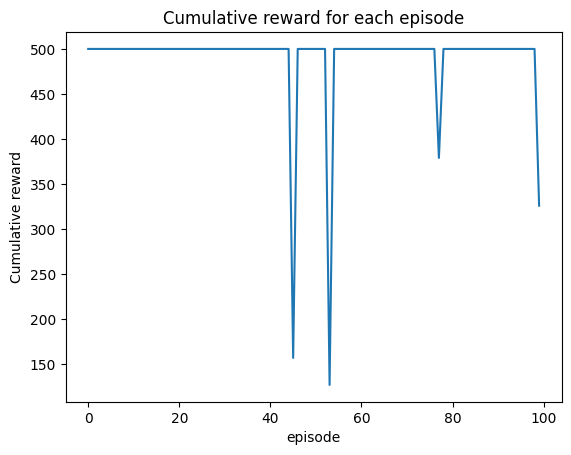

In [41]:
plt.plot(eval_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [42]:
mean = sum(eval_rewards) / len(eval_rewards)
print(mean)

489.89


In [43]:
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 489.89
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [48]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()

# Assuming you have already defined and trained your MonteCarloAgent (agent)
# and have state_space_size and action_space_size defined

# Initialize the agent here (if not already done)
agent = MonteCarloAgent(env.action_space.n, alpha=0.05, gamma=0.99, epsilon=0.15)

while True:
    env.render()

    # Get the current state and discretize it
    state = discretize_state(observation)

    # Choose an action using the agent's policy
    action = agent.choose_action(state)

    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
